In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.


In [2]:
!mkdir -p models

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in coarse_crop + fine_crop:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Coarse Tuning

In [6]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=coarse_crop)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


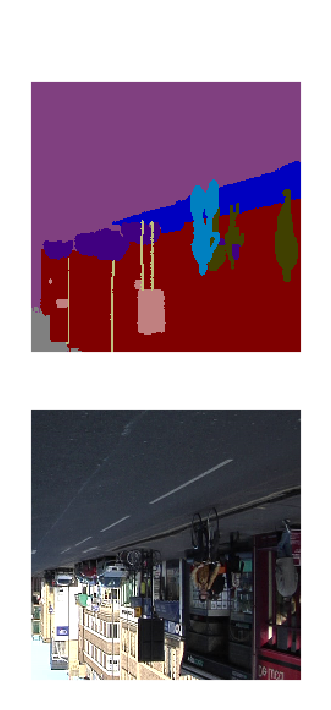

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [8]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,
    learning_rate=1e-3,
)

In [ ]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=50,
    steps_per_epoch=int(367 / 3),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [ ]:
history_to_results(history)

## Test Metrics

In [ ]:
metrics = model.evaluate_generator(generators['test'], steps=233)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

## Qualitative Results

In [ ]:
def predict(generator):
    X, y = next(generator)
    p = model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

In [ ]:
X, y, p = predict(generators['train'])

In [ ]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

In [ ]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

### Validation

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

### Test

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [ ]:
# serialize weights to HDF5
model.save_weights('models/Tiramisu103-CamVid11-coarse.h5')

# Clear Session

remove the current model from memory.

In [ ]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [ ]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=fine_crop, batch_size=1)
generators = camvid11.generators()

In [ ]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [ ]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/Tiramisu103-CamVid11-coarse.h5')

In [ ]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['train'],
    epochs=50,
    steps_per_epoch=367,
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=50),
        PlotLossesKeras(),
    ],
    verbose=0,
    max_queue_size=1
)

In [ ]:
history_to_results(history)

## Test Metrics

In [ ]:
metrics = tune_model.evaluate_generator(generators['test'], steps=233)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

## Qualitative Results

In [ ]:
def predict(generator):
    X, y = next(generator)
    p = tune_model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

In [ ]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

### Validation

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

### Test

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [ ]:
# serialize weights to HDF5
tune_model.save_weights('models/Tiramisu103-CamVid11-fine.h5')